In [2]:
import os
import tensorflow as tf
import cv2 as cv
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from ipynb.fs.full.preProcess import basic_preProcess, category_preProcess, color_preProcess, augment_contrast

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPooling2D,Activation,Dropout,Lambda,Dense,Flatten, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Concatenate

from collections import Counter

In [3]:
# For Local File:

# For Google Colab:
# from google.colab import drive
# drive.mount('/content/drive')

# train_dir = './train/'
# test_dir = './test/'
# train_df = pd.read_csv('./train.csv')

train_dir = './train/'
test_dir = './test/'
train_df = pd.read_csv('./train.csv')

In [4]:
train_data_color = []
train_data_category = []

train_jenis = []
train_warna =[]

test_data = []
test_ids = []

train_shapes = []
test_shapes = []


input_shape = (224, 224, 3)
for i in os.listdir(train_dir):
    if(i is not None):
        img_path = os.path.join(train_dir, i)
        img = cv.imread(img_path)
        if(img is not None):

          h,w = img.shape[:2]
          train_shapes.append((h,w))
          img_ca = img.copy()
          img_co = img.copy()
          img_category = category_preProcess(img_ca)
          img_color = color_preProcess(img_co)

          img_color_output = basic_preProcess(img_color)
          img_category_output = basic_preProcess(img_category)
          """
            Image yang sudah dibaca akan dilakukan preprocess sesuai dengan tipe mereka entah category atau color dan akan dijalankan basic_preProcess yang berguna untuk mereshape gambarnya. 
          """

          train_data_color.append(img_color_output)
          train_data_category.append(img_category_output)
          cv.imwrite('./processed_train/color/'+i,cv.cvtColor(img_color_output,cv.COLOR_RGB2BGR))
          cv.imwrite('./processed_train/category/'+i,img_category_output)
          """
            Memasukkan gambar ke dalam array dan mengoutput gambar ke dalam file
          """

          cond = train_df['id'] == int(i[:-4])
          idx = train_df.loc[cond].index[0]
          train_jenis.append(train_df.iloc[idx]['jenis'])
          train_warna.append(train_df.iloc[idx]['warna'])

        else:
          print("no image found")
  
"""
    Looping ini secara garis besar berguna untuk membaca data dari train_dir, setelah itu di preprocess, kemudian disimpan dalam array dan diwrite supaya dapat menurunkan bobot komputasi saat membaca dataset. 
"""


'\n    Looping ini secara garis besar berguna untuk membaca data dari train_dir, setelah itu di preprocess, kemudian disimpan dalam array dan diwrite supaya dapat menurunkan bobot komputasi saat membaca dataset. \n'

In [5]:
test_data_color = []
test_data_category = []
for i in os.listdir(test_dir):
    if(i is not None):
      img_path = os.path.join(test_dir, i)
      img = cv.imread(img_path)
      if(img is not None):
        h,w = img.shape[:2]
        test_shapes.append((h,w))
        img_test_ca = img.copy()
        img_test_co = img.copy()

        img_test_color = color_preProcess(img_test_co)
        img_test_category = category_preProcess(img_test_ca)

        img_test_color_output = basic_preProcess(img_test_color)
        img_test_category_output = basic_preProcess(img_test_category)

        # test_data.append(img)
        test_data_color.append(img_test_color_output)
        test_data_category.append(img_test_category_output)

        cv.imwrite('./processed_test/color/'+i,cv.cvtColor(img_test_color_output,cv.COLOR_RGB2BGR))
        cv.imwrite('./processed_test/category/'+i,img_test_category_output)
        
        test_data.append(img)
        test_ids.append(i[:-4])
      else:
        print("no image found")
"""
    Looping ini secara garis besar berguna untuk membaca data dari test_dir, setelah itu di preprocess, kemudian disimpan dalam array dan diwrite supaya dapat menurunkan bobot komputasi saat membaca dataset. 
"""

'\n    Looping ini secara garis besar berguna untuk membaca data dari test_dir, setelah itu di preprocess, kemudian disimpan dalam array dan diwrite supaya dapat menurunkan bobot komputasi saat membaca dataset. \n'

In [6]:
# augment
max_len = len(train_data_category)

for img_raw, warna in zip(train_data_color[:int(max_len*0.75)],train_warna[:int(max_len*0.75)]):
   if warna not in [3]:
      # print(warna)
      train_data_color.append(augment_contrast(img_raw))
      train_warna.append(warna)

"""
    Looping ini berguna untuk melakukan augmentasi pada gambar dikarenakan data color yang ada cukup imbalance yaitu dengan class terbanyak berjumlah 234 dan yang terendah berjumlah 116. Augmentasi yang dilakukan yaitu dengan memanipulasi contrast.
"""

'\n    Looping ini berguna untuk melakukan augmentasi pada gambar dikarenakan data color yang ada cukup imbalance yaitu dengan class terbanyak berjumlah 234 dan yang terendah berjumlah 116. Augmentasi yang dilakukan yaitu dengan memanipulasi contrast.\n'

In [7]:
print(len(train_df))
print("================")
print(train_df.describe())
print("================")
print(train_df.dtypes)
print("================")
print(train_df.isna().sum())
print("================")
print("duplicated : ",train_df.duplicated().sum())

"""
    Berfungsi untuk melihat tipe data, persebaran pada train.csv yang diberikan. Setelah itu untuk mengecek apakah ada yang kosong maupun duplikat pada datanya. Berdasarkan hasil penemuan tidak ada yang kosong maupun duplikat. 
"""

777
               id       jenis       warna
count  777.000000  777.000000  777.000000
mean   389.000000    0.387387    2.202059
std    224.444871    0.487467    1.319597
min      1.000000    0.000000    0.000000
25%    195.000000    0.000000    1.000000
50%    389.000000    0.000000    2.000000
75%    583.000000    1.000000    3.000000
max    777.000000    1.000000    4.000000
id       int64
jenis    int64
warna    int64
dtype: object
id       0
jenis    0
warna    0
dtype: int64
duplicated :  0


'\n    Berfungsi untuk melihat tipe data, persebaran pada train.csv yang diberikan. Setelah itu untuk mengecek apakah ada yang kosong maupun duplikat pada datanya. Berdasarkan hasil penemuan tidak ada yang kosong maupun duplikat. \n'

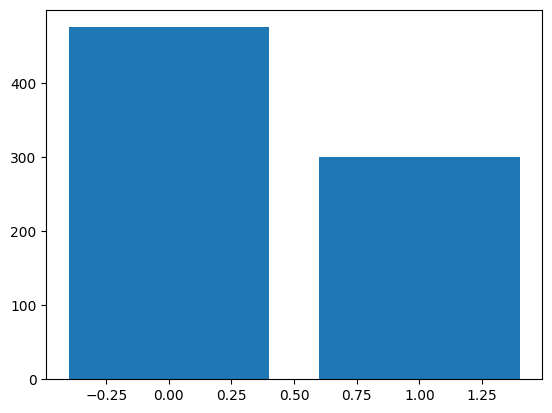

dict_keys([1, 0]) dict_values([301, 476])


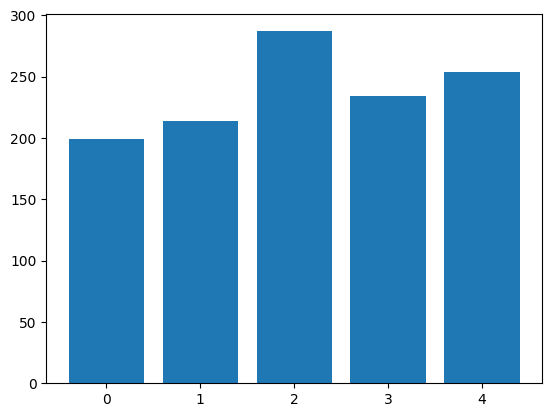

dict_keys([1, 0, 3, 2, 4]) dict_values([214, 199, 234, 287, 254])


'\n    Untuk melihat persebaran kelas pada jenis dan color. Hasil ini sudah membuktikan untuk data color sudah tidak imbalance lagi. \n'

In [8]:
# print(train_jenis)
jenis_counts = Counter(train_jenis) 
plt.bar(jenis_counts.keys(), jenis_counts.values())
plt.show()
print(jenis_counts.keys(), jenis_counts.values())

warna_counts = Counter(train_warna)
plt.bar(warna_counts.keys(), warna_counts.values())
plt.show()
print(warna_counts.keys(), warna_counts.values())

"""
    Untuk melihat persebaran kelas pada jenis dan color. Hasil ini sudah membuktikan untuk data color sudah tidak imbalance lagi. 
"""

In [9]:
print(train_shapes)
print(test_shapes)


"""
    Untuk melihat dimensi gambar pada dataset sebelum dilakukan preprocessing.
"""

[(200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (200, 200), (20

'\n    Untuk melihat dimensi gambar pada dataset sebelum dilakukan preprocessing.\n'

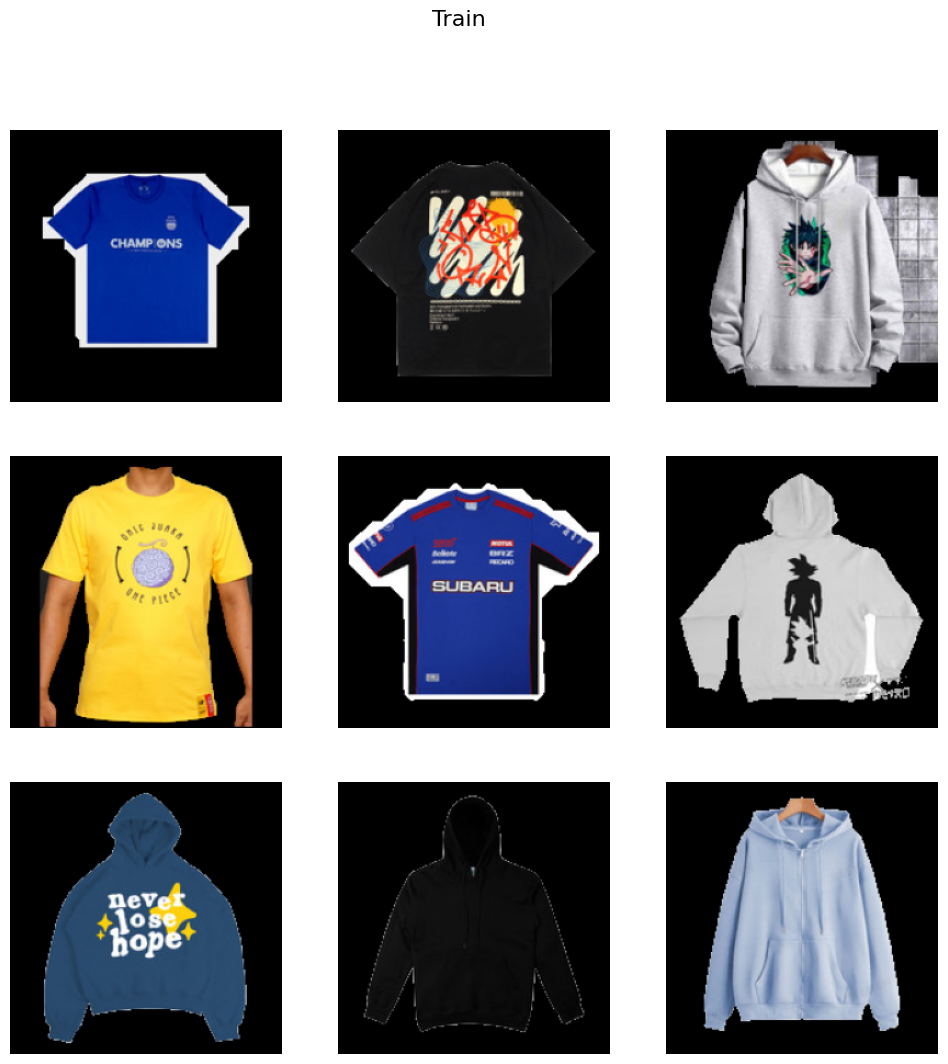

'\n    Melihat 9 gambar rando yang ada pada dataset yang sudah dipreprocess\n'

In [10]:
sample_images = np.random.choice(len(train_data_category), size=9, replace=False)
plt.figure(figsize=(12, 12))
for idx, curr in enumerate(sample_images, start=1):
    img_show = train_data_category[curr]
    img_show = cv.cvtColor(img_show,cv.COLOR_BGR2RGB)

    plt.subplot(3, 3, idx)
    plt.imshow(img_show)
    plt.axis('off')
plt.suptitle("Train", fontsize=16)
plt.show()

"""
    Melihat 9 gambar rando yang ada pada dataset yang sudah dipreprocess
"""

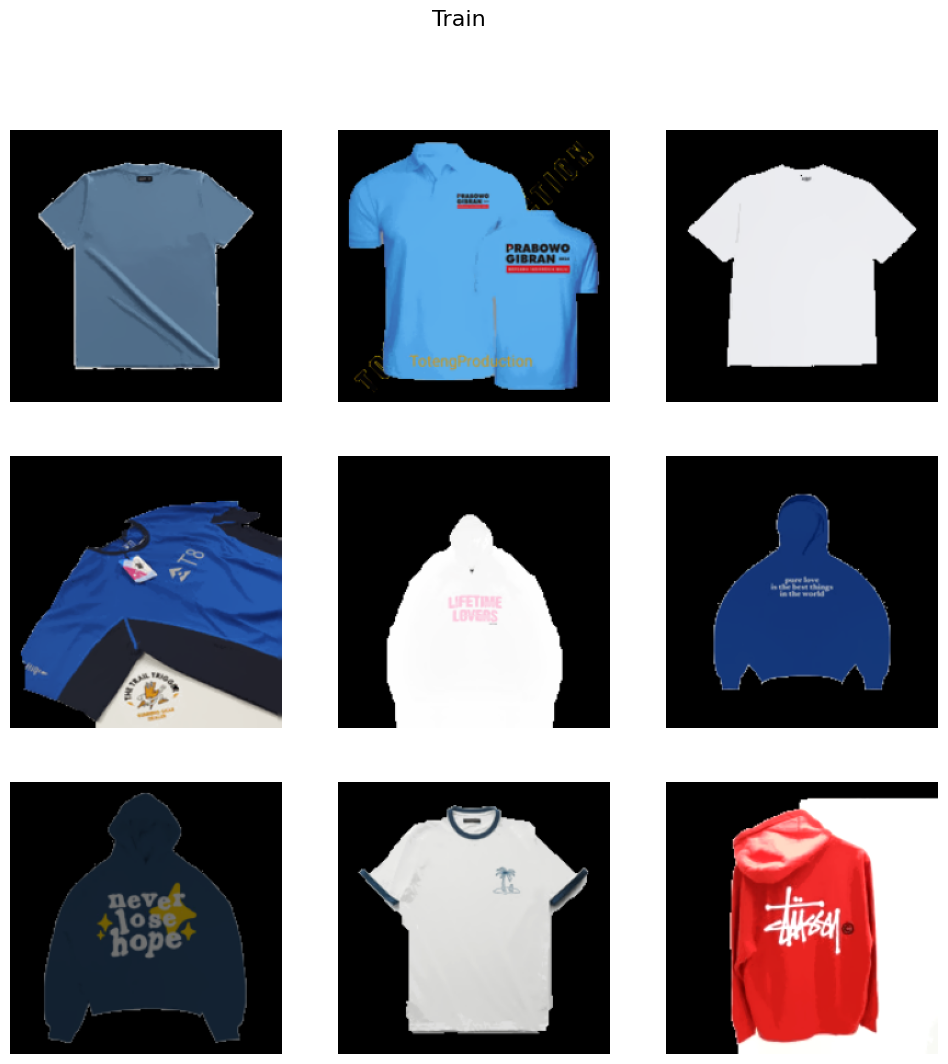

In [11]:
sample_images = np.random.choice(len(train_data_color), size=9, replace=False)
plt.figure(figsize=(12, 12))
for idx, curr in enumerate(sample_images, start=1):
    img = train_data_color[curr]
    plt.subplot(3, 3, idx)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle("Train", fontsize=16)
plt.show()